# DDPM & DDPM Improved

In this Notebook we are implementing a simple diffusion model for generating Anime Faces.

In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt



In [2]:
transforms = v2.Compose(
    [
        v2.RandomResizedCrop(size = (64,64), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    ]
)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
dataset = ImageFolder(root= '/kaggle/input/animefacedataset',
                            transform = transforms,
                            target_transform = None
                           )

In [5]:
BATCH_SIZE = 64

Data_loader = DataLoader(
    dataset = dataset,
    batch_size = BATCH_SIZE,
    num_workers = 2,
    shuffle = True
)


torch.Size([64, 64, 3])


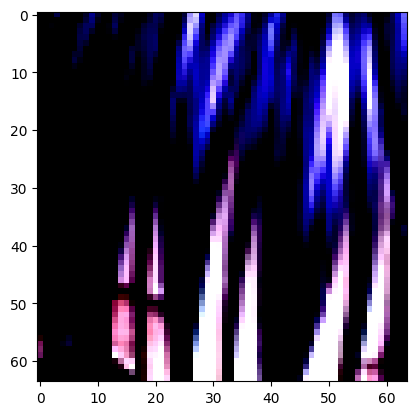

In [6]:
image, label = next(iter(Data_loader))
# transposed image for matplotlib
img_transposed = image[0].permute(1,2,0)
print(img_transposed.shape)

import matplotlib.pyplot as plt
plt.imshow(img_transposed)
plt.show()

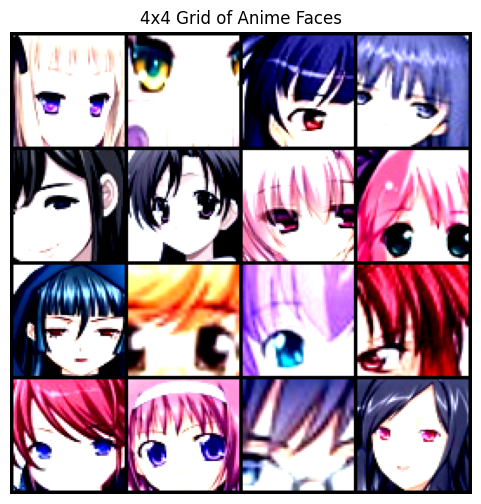

In [7]:
img, label = next(iter(Data_loader))
## Taking first 16 images and making grid of4X4
image_grid = make_grid(img[:16], nrow = 4, normalize = True,  value_range=(-1,1))
## converting them to nu py
npimg = image_grid.permute(1, 2, 0).cpu().numpy()
# Plot
plt.figure(figsize=(6, 6))
plt.imshow(npimg)
plt.axis('off')
plt.title("4x4 Grid of Anime Faces")
plt.show()


# Forward Process

We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually. 

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [8]:
def extract(a, t, x_shape):
    """
    a: tensor of [T]
    t: tensor of [B]
    Returns a tensor shaped like x with values from a at indices t
    """
    batch_size = t.shape[0]
    out = a.gather(-1, t).float()  # shape [B]
    return out.reshape(batch_size, 1, 1, 1)  # so it can broadcast over [B, C, H, W]


In [9]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# def forward_diffusion_sample(x_0, t, device="cuda"):
#     """ 
#     Takes an image and a timestep as input and 
#     returns the noisy version of it
#     """
#     noise = torch.randn_like(x_0)
#     sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
#     sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
#         sqrt_one_minus_alphas_cumprod, t, x_0.shape
#     )
#     # mean + variance
#     return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
#     + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)



# Utility function to extract coefficients for batch-wise indexing
def extract(a, t, x_shape):
    """
    a: Tensor of shape [T] - likely on CPU
    t: Tensor of shape [B] - likely on GPU
    x_shape: Shape of x_0
    Returns: Tensor of shape [B, 1, 1, 1]
    """
    # Move a to same device as t
    a = a.to(t.device)
    batch_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(batch_size, 1, 1, 1)


# Forward diffusion step
def forward_diffusion_sample(x_0, t, device="cuda"):
    noise = torch.randn_like(x_0)
    # print(x_0.shape)
    x_0 = x_0[:64]


    # Assume sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod are global tensors of shape [T]
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_0.shape).to(device)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_0.shape).to(device)

    # Forward noisy image
    x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    return x_t, noise

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [10]:
image = next(iter(Data_loader))[0]
print(image.shape)

torch.Size([64, 3, 64, 64])


/tmp/ipykernel_31/1585734977.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


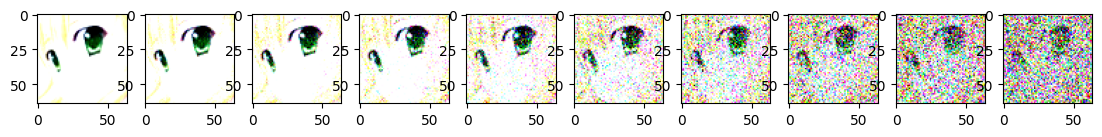

In [11]:
IMG_SIZE = 64
BATCH_SIZE = 128
image = next(iter(Data_loader))[0]
image = image.to(device)
# print(image.shape)

# Simulate forward diffusion
def show_tensor_image(image):
    # If image has batch dimension, remove it
    if image.dim() == 4:
        image = image[0]
    image = image.detach().cpu()
    image = (image * 0.5) + 0.5  # Assuming images were normalized to [-1, 1]
    image = image.clamp(0, 1)
    plt.imshow(image.permute(1, 2, 0))  # [C, H, W] -> [H, W, C]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    t = t.to(device)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t, device)
    show_tensor_image(img)

# The backward process = U-Net

For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed

In [12]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

# The loss

Key Takeaways:

After some maths we end up with a very simple loss function
There are other possible choices like L2 loss ect.

In [13]:
# def get_loss(model, x_0, t):
#     x_noisy, noise = forward_diffusion_sample(x_0, t, device)
#     noise_pred = model(x_noisy, t)
#     return F.l1_loss(noise, noise_pred)

def get_loss(model, x_0, t=None):
    if t is None:
        t = torch.randint(0, T, (x_0.shape[0],), device=x_0.device)
    x_noisy, noise = forward_diffusion_sample(x_0, t, device=x_0.device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)


# Sampling

In [14]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

# Training

Epoch 0 | step 000 Loss: 0.8099085688591003 


/tmp/ipykernel_31/364762590.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


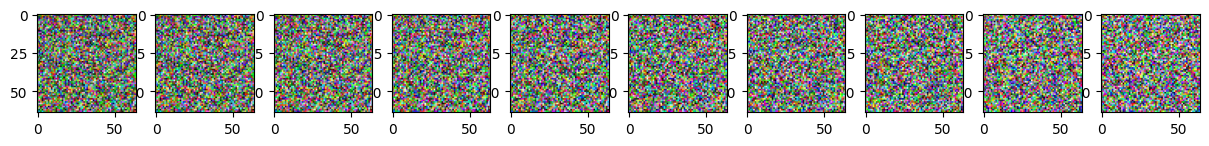

Epoch 5 | step 000 Loss: 0.18709084391593933 


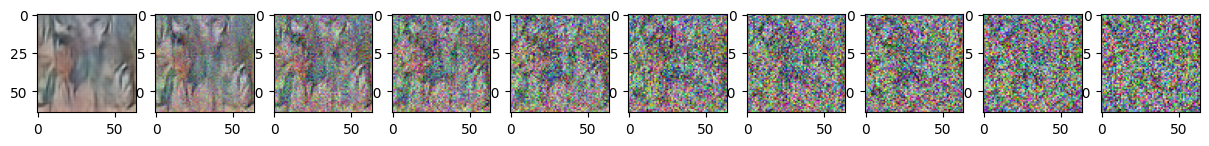

Epoch 10 | step 000 Loss: 0.15108133852481842 


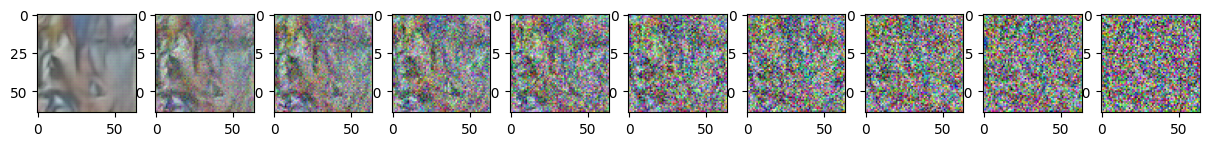

Epoch 15 | step 000 Loss: 0.1802595555782318 


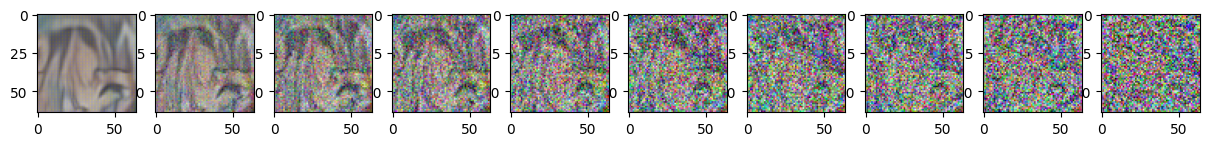

Epoch 20 | step 000 Loss: 0.157257080078125 


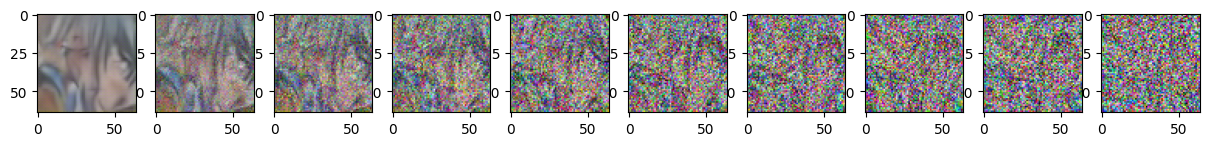

Epoch 25 | step 000 Loss: 0.17430631816387177 


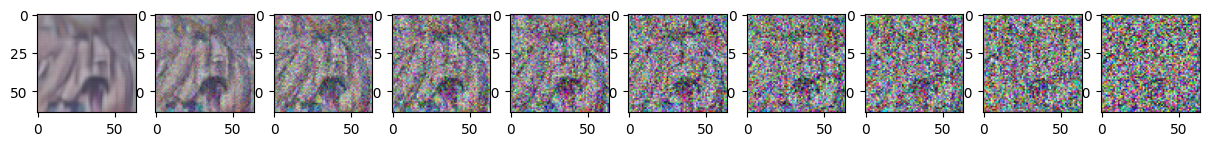

Epoch 30 | step 000 Loss: 0.17696663737297058 


In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(Data_loader):
      optimizer.zero_grad()

      x_0 = batch[0].to(device)
      t = torch.randint(0, T, (x_0.shape[0],), device=device)  # Dynamically match batch size
      #print(f"x_0 shape: {x_0.shape}, t shape: {t.shape}")

      loss = get_loss(model, x_0, t)

      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()